# L10b: Implementation of the Weighted Majority Algorithm for Online Learning
In this lab, we will implement and explore the Weighted Majority Algorithm for online learning in a daily growth rate guessing game. Before we start, please review the Weighted Majority Algorithm.

> __Learning Objectives:__
>
> After completing this activity, students will be able to:
> 
> **Understand the Weighted Majority Algorithm:** We explore the theoretical foundations of the Weighted Majority Algorithm, including how it combines expert predictions through adaptive weighting and provides theoretical guarantees on prediction performance. This approach connects online learning concepts with ensemble methods for sequential decision-making.
> 
> **Implement the Weighted Majority Algorithm:** We build and execute the WMA algorithm using simple expert strategies based on stock growth rates to predict SPY ETF movements. The implementation demonstrates how to construct and combine multiple prediction strategies in an online learning framework.
> 
> **Validate theoretical mistake bounds:** We empirically test the algorithm's theoretical guarantee that aggregator mistakes are bounded relative to the best expert's performance. The validation uses a 252-day simulation to confirm the mathematical bounds hold in practice.

This is going to be cool, so let's get started!

___

## Background: Weighted Majority Algorithm
Let's start with the Weighted Majority Algorithm developed by [Littlestone and Warmuth in 1994](https://www.sciencedirect.com/science/article/pii/S0890540184710091). We illustrate this approach with an example found in [Arora et al., 2005, Princeton](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-6/L6a/docs/Arora-MWsurvey-CS-Princeton.pdf), which is a _prediction from expert advice_ problem. Let's take a look at the framing: 

* __Game__: The game's objective is to predict the daily stock price movement as either `up` or `down,` (which we encode as `{1 | -1}`). Each morning, we forecast the daily price direction, and by market close, we learn the actual movement. If we predict _incorrectly_, we lose a dollar. We aim to minimize losses. Our predictions are informed by the forecasts of $n$ experts, whose predictions may be correlated and accurate or inaccurate.
* __Goal__: The weighted majority algorithm limits losses to about the best expert without knowing who that is until the end of the sequence. Each day requires a decision. The algorithm maintains weights for experts, initially giving them equal weight. Over time, experts who make mistakes have their weights decreased, while those who predict correctly maintain higher relative influence.

We play this game between an omniscient _adversary_ (nature, i.e., the market) and an _aggregator_ (us) who $n$ experts advise; we select $n$ as odd to avoid ties. The game proceeds in rounds $t = 1, 2, \ldots, T$. During each round, the aggregator (us) makes a _binary_ decision $y_t \in \{-1, 1\}$, and the adversary (market) reveals the true outcome $y_t$. Initially, the experts have weights $\left\{w_{i}^{(1)} = 1 \mid i = 1, 2, \ldots, n\right\}$. 

### Algorithm
For each round $t=1,2,\dots,T$:
1. The aggregator (us) makes a prediction $y_t \in \{-1, 1\}$ based on the weighted majority of the experts' predictions. If the sum of weights of experts predicting `1` is greater than or equal to half the total weight of all experts, predict `1`; otherwise, predict `-1`.
2. The adversary (market) reveals the actual outcome $y_t \in \{-1, 1\}$.
3. We decrease the weights of the experts who predicted incorrectly. For each expert $i$ who predicted incorrectly, we update the weight: $w_{i}^{(t+1)} = w_{i}^{(t)}(1-\epsilon)$, where $0<\epsilon\leq{1/2}$ is a learning rate parameter.

__Theorem__: The weighted majority algorithm has the following theoretical guarantee (which bounds the number of mistakes the aggregator makes). Let $m_{i}^{(t)}$ be the number of mistakes made by expert $i$ up to time $t$ and $m^{(t)}$ be the total number of mistakes made by the aggregator (us). Then, for every expert $i$ and the aggregator, we have:
$$
\begin{align*}
m^{(t)} \leq \frac{2\ln(n)}{\epsilon} + 2\left(1+\epsilon\right)m_{i}^{(t)}
\end{align*}
$$

___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include-solution.jl")); # include the Include.jl file

### Data
We gathered a daily open-high-low-close dataset for each firm in the S&P 500 from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

2767

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end;

Finally, let's get a list of the firms in our cleaned dataset (and sort them alphabetically). We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort # list of firm "ticker" symbols in alphabetical order

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 ⋮
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

Finally, let's set up a ticker map that holds the index of each ticker value. We'll save this in the `tickerindexmap::Dict{String,Int}` dictionary:

In [6]:
tickerindexmap = let

    # initialize -
    tickerindexmap = Dict{String,Int}();
    for i ∈ eachindex(list_of_tickers)
        tickerindexmap[list_of_tickers[i]] = i;
    end

    tickerindexmap;
end

Dict{String, Int64} with 424 entries:
  "EMR"  => 132
  "CTAS" => 101
  "HSIC" => 187
  "KIM"  => 217
  "PLD"  => 310
  "IEX"  => 194
  "BAC"  => 48
  "CBOE" => 69
  "EXR"  => 144
  "NCLH" => 271
  "CVS"  => 103
  "DRI"  => 119
  "DTE"  => 120
  "ZION" => 423
  "AVY"  => 43
  "EW"   => 140
  "EA"   => 124
  "NWSA" => 289
  "CAG"  => 65
  ⋮      => ⋮

### Compute the growth rate matrix
Next, let's compute the growth rate array which contains, for each day and each firm in our dataset, the value of the growth rate between time $j$ and $j-1$. 

>  __Continuously Compounded Growth Rate (CCGR)__
>
> Let's assume a model of the share price of firm $i$ is governed by an expression of the form:
>$$
\begin{align*}
S^{(i)}_{j} &= S^{(i)}_{j-1}\;\exp\left(g^{(i)}_{j,j-1}\Delta{t}_{j}\right)
\end{align*}
$$
> where $S^{(i)}_{j-1}$ denotes the share price of firm $i$ at time index $j-1$, $S^{(i)}_{j}$ denotes the share price of firm $i$ at time index $j$, and $\Delta{t}_{j} = t_{j} - t_{j-1}$ denotes the length of a time step (units: years) between time index $j-1$ and $j$. The value we are going to estimate is the growth rate $g^{(i)}_{j,j-1}$ (units: inverse years) for each firm $i$, and each time step in the dataset.

We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned dataset and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array.

In [7]:
growth_rate_array = let

    # initialize -
    τ = (1/252); # time-step one-day in units of years (trading year is 252 days)
    r̄ = 0.0; # assume the risk-free rate is 0

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = τ, 
        risk_free_rate = r̄); # other optional parameters are at their defaults

    growth_rate_array; # return
end;

___

## Task 1: Implement the Weighted Majority Algorithm
In this task, we'll implement a data-driven expert strategy in which we use growth rate data from other tickers to predict whether the SPY ETF (tracking the S&P 500) will go up or down during a trading day.

First, we'll define the `expert` function.

> __Expert Function__: The `expert(index::Int, time::Int, data::Array{Float64,2})::Int` function takes the `index::Int` of the expert, the current time step `t::Int`, and the `data::Array{Float64,2}` array (which contains the actual growth rate data). This function returns the _prediction_ from expert $i$, namely $y_{t}^{(i)}$.

Let's take a look at the implementation of the `expert(...)` function:

In [8]:
function expert(index::Int, time::Int, data::Array{Float64,2})::Int

    # These are my choices for experts: you pick yours
    # These experts use the growth rate data from other tickers to predict the SPY growth rate
    # But we don't know which ones are best!
    # expert 1: QQQ
    # expert 2: NVDA
    # expert 3: AMD
    # expert 4: AAPL
    # expert 5: MSFT
    
    i = nothing;
    if (index == 1)
        i = tickerindexmap["QQQ"]; # expert one uses QQQ growth rate data: SPY and QQQ are highly correlated
    elseif (index == 2)
        i = tickerindexmap["NVDA"];
    elseif (index == 3)
        i = tickerindexmap["AMD"];
    elseif (index == 4)
        i = tickerindexmap["AAPL"];
    elseif (index == 5)
        i = tickerindexmap["MSFT"];
    end

    return data[time,i] |> sign;
end;

Next, we'll define the `adversary` function.

> __Adversary Function__: The `adversary(time::Int, data::Array{Float64,2})::Int` function takes the current time step `t::Int` and the `data::Array{Float64,2}` array and returns the true answer $y_{t}$ for the `SPY` growth rate for time $t$:

Take a look at the implementation of the `adversary(...)` function:

In [9]:
function adversary(time::Int, data::Array{Float64,2})::Int

    # Adversary: This is the true answer for the growth rate
    # The adversary uses the actual SPY growth rate data
    result = tickerindexmap["SPY"] |> i-> data[time,i] |> sign;
    return result
end;

Next, we'll build [a `model::MyBinaryWeightedMajorityAlgorithmModel` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/online/#VLDataScienceMachineLearningPackage.MyBinaryWeightedMajorityAlgorithmModel) that holds all the data associated with the problem [using a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/). 

In [10]:
model = let

    # initialize -
    T = 252; # number of rounds (days)
    ϵ = 10.0/T; # learning rate (you can tune this parameter)

    # build -
    model = build(MyBinaryWeightedMajorityAlgorithmModel, (
        ϵ = ϵ, # learning rate
        n = 5, # number of experts (needs to be odd to avoid ties)
        T = T, # number of rounds
        expert = expert, # expert function
        adversary = adversary, # adversary function
    ));

    # return the model -
    model;
end;

Finally, we call [the `play(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/online/#VLDataScienceMachineLearningPackage.play) to run the simulation. The [`play(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/online/#VLDataScienceMachineLearningPackage.play) takes the `model::MyBinaryWeightedMajorityAlgorithmModel` instance and the data matrix `D̄::Array{Float64,2}` and returns two arrays:
* The `sims::Array{Float64,2}` holds simulation information. Each row corresponds to a time `t.` The first $n$ columns correspond to the predictions of experts $i=1,2,\dots,n$ at a time `t.` Column $n+1$ corresponds to the aggregator (us) prediction, and column $n+2$ corresponds to the adversary prediction at time `t.` Finally, the last column holds the loss value $l_{t}$ for the aggregator.
* The `weights::Array{Float64,2}` array holds the weights for each expert in our system. The rows of this array correspond to the timesteps `t`, while each column holds the $w_{i}^{(t)}$ values.

So what do we see?

In [11]:
(sims, weights) = play(model, growth_rate_array);

What's in the `sims::Array{Float64,2}` array? 

In [12]:
sims

252×8 Matrix{Int64}:
 -1   1   1  -1  -1  -1  -1  0
  1   1   1   1   1   1   1  0
  1   1   1   1  -1   1   1  0
 -1  -1  -1  -1  -1  -1   1  1
 -1  -1   1  -1   1  -1   1  1
 -1  -1   1   1  -1  -1  -1  0
  1   1   1   1   1   1   1  0
  1   1   1   1   1   1   1  0
  1   1  -1  -1   1   1  -1  1
 -1   1  -1  -1  -1  -1  -1  0
  ⋮                   ⋮      
  1   1   1   1   1   1   1  0
 -1   1   1  -1   1  -1   1  1
  1  -1  -1  -1  -1   1   1  0
  1  -1   1   1  -1   1   1  0
  1  -1  -1   1  -1   1   1  0
 -1  -1  -1  -1  -1  -1  -1  0
 -1  -1   1  -1  -1  -1  -1  0
 -1  -1   1  -1   1  -1  -1  0
 -1  -1  -1  -1  -1  -1  -1  0

What's in the `weights::Array{Float64,2}` array?

In [13]:
weights

253×5 Matrix{Float64}:
 1.0       1.0        1.0        1.0        1.0
 1.0       0.960317   0.960317   1.0        1.0
 1.0       0.960317   0.960317   1.0        1.0
 1.0       0.960317   0.960317   1.0        0.960317
 0.960317  0.92221    0.92221    0.960317   0.92221
 0.92221   0.885614   0.92221    0.92221    0.92221
 0.92221   0.885614   0.885614   0.885614   0.92221
 0.92221   0.885614   0.885614   0.885614   0.92221
 0.92221   0.885614   0.885614   0.885614   0.92221
 0.885614  0.850471   0.885614   0.885614   0.885614
 ⋮                                          
 0.206148  0.0520334  0.0408104  0.0442529  0.0295182
 0.197967  0.0520334  0.0408104  0.0424968  0.0295182
 0.197967  0.0499686  0.039191   0.0408104  0.0283468
 0.197967  0.0479857  0.039191   0.0408104  0.027222
 0.197967  0.0460815  0.0376358  0.0408104  0.0261417
 0.197967  0.0460815  0.0376358  0.0408104  0.0261417
 0.197967  0.0460815  0.0361423  0.0408104  0.0261417
 0.197967  0.0460815  0.0347081  0.0408104  0

What fraction of the time did the aggregator (us) predict correctly?

In [14]:
findall(x-> x == 0, sims[:,end]) |> i-> length(i)/252

0.8253968253968254

### Visualize the expert weights
`Unhide` the code block below to see how we plotted the weights versus $t$ for the experts in our system. 

> __What do you observe?__ The weights of the experts are updated over time, and the algorithm adapts its predictions based on the performance of each expert. All experts start with equal weights, but as the game progresses, those who make accurate predictions gain more influence, while those who make mistakes see their weights decrease. 

So which experts ended up with the highest weights?

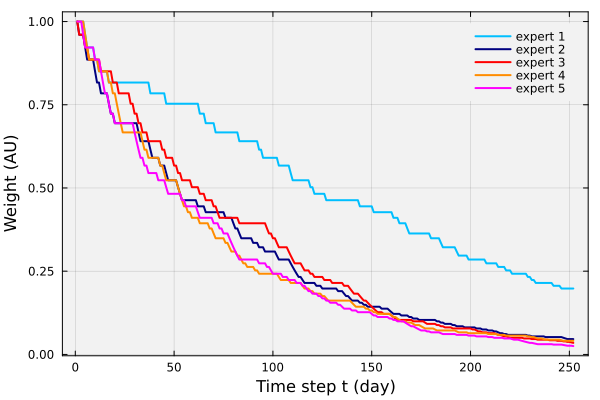

In [15]:
let
    # initialize -
    T = 252; # number of rounds (days)
    daystoplot = 1:T;

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); 
    plot!(weights[daystoplot,1], c=:deepskyblue1, lw=2, label="expert 1")
    plot!(weights[daystoplot,2],c=:navy, lw=2, label="expert 2")
    plot!(weights[daystoplot,3],c=:red, lw=2, label="expert 3")
    plot!(weights[daystoplot,4],c=:darkorange, lw=2, label="expert 4")
    plot!(weights[daystoplot,5],c=:magenta, lw=2, label="expert 5")
    xlabel!("Time step t (day)", fontsize=18)
    ylabel!("Weight (AU)", fontsize=18)
end

___

## Task 2: Test the theoretical mistake bound
In this task, we'll test the theorem governing the upper bound on the number of mistakes an aggregator (us) will make relative to the system's experts.

> __Theorem__: The weighted majority algorithm has the following theoretical guarantee (which bounds the number of mistakes the aggregator makes). Let $m_{i}^{(t)}$ be the number of errors made by expert $i$ up to time $t$ and $m^{(t)}$ be the total number of errors made by the aggregator (us) up to time $t$. Then, for every expert $i$ and the aggregator, we have:
>$$
\begin{align*}
m^{(t)} \leq \frac{2\ln(n)}{\epsilon} + 2\left(1+\epsilon\right)m_{i}^{(t)}
\end{align*}
$$

Let's start by identifying the best expert in hindsight.

__Which expert was best__? Let's use the _heuristic_ that the best expert will be the one with the highest weight at the end of the game, i.e., $\hat{i} = \text{arg}\max\left(w_{1}^{(T)},w_{2}^{(T)},\dots,w_{n}^{(T)}\right)$

In [16]:
î = argmax(weights[end,:]) # index of the largest weight at the end

1

Next, we'll compute the number of mistakes by our experts as a function of time $t$. We'll save this in the `m_experts::Array{Int64,2}` array where each row corresponds to a time index $t$, and each column is loss suffered by each expert. 

In this case, if the expert was _incorrect_ they have a loss of `1`; otherwise, they have a loss of `0`.

In [17]:
m_experts = let

    # data -
    n = model.n; # number of experts
    T = model.T; # number of rounds in the game
    m = Array{Int64,2}(undef, T, n);

    for t ∈ 1:T
        for j ∈ 1:n
            expert_prediction = sims[t,j];
            adversary_prediction = sims[t,end-1]; # adv is the penultimate column
            m[t,j] = expert_prediction == adversary_prediction ? 0 : 1
        end
    end

    # return 
    m
end;

### Compute the bound
Finally, let's compute the bound. We save the left side of the bound (the aggregator term) in the `L::Array{Float64,1}` variable, while the right side is saved in the `R::Array{Float64,1}` variable. 

In [18]:
L,R = let

    # data -
    n = model.n; # number of experts
    T = model.T; # number of rounds in the game
    ϵ = model.ϵ; # Get the learning rate
    L = Array{Float64,1}(undef, T); # left term
    R = Array{Float64,1}(undef, T); # right term
    m_aggregator = sims[:,end]; # aggregator mistakes on the last column
    m_expert = m_experts[:,î]; # best expert

    # compute the left term L
    for t ∈ 1:T
        L[t] = sum(m_aggregator[1:t]);
    end
    
    # compute the right term R
    for t ∈ 1:T
        R[t] = (2*log(n)/ϵ) + 2*(1+ϵ)*sum(m_expert[1:t])
    end
    
    L,R
end;

`Unhide` the code block below to see how we plotted the `L` and `R` components of the theoretical bound expression.

> __What do we expect?__ The left side of the inequality (the actual mistakes made by the aggregator) should always be less than or equal to the right side of the inequality (the theoretical bound). This confirms the validity of the theoretical mistake bound for the weighted majority algorithm in this specific scenario. The gap between the two sides may vary over time, but the inequality consistently holds true throughout the duration of the game.

So what do we see?

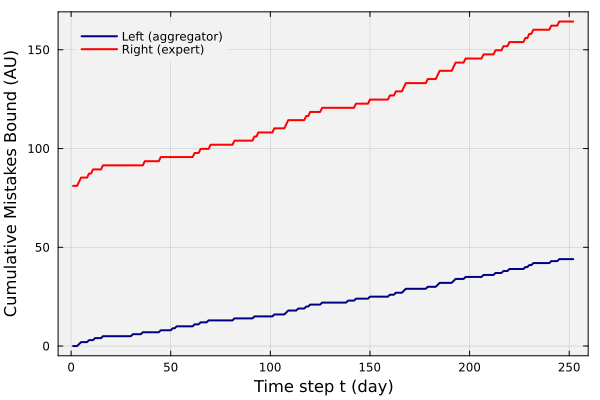

In [19]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot!(L, c=:navy, lw=2, label="Left (aggregator)")
    plot!(R, c=:red, lw=2, label="Right (expert)")
    xlabel!("Time step t (day)", fontsize=18)
    ylabel!("Cumulative Mistakes Bound (AU)", fontsize=18)
end

___

## Summary
In this lab, we implemented and tested the Weighted Majority Algorithm for online learning in a stock price prediction game.

> __Key Takeaways:__
>
> * **Adaptive expert weighting:** The Weighted Majority Algorithm dynamically adjusts expert influence based on prediction accuracy. Experts who perform well gain higher weights, while those who make mistakes see their influence decrease, allowing the system to adapt to changing market conditions.
> * **Theoretical mistake bound validation:** We empirically verified the algorithm's theoretical guarantee that aggregator mistakes are bounded relative to the best expert's performance. The bound $m^{(t)} \leq \frac{2\ln(n)}{\epsilon} + 2(1+\epsilon)m_{i}^{(t)}$ held throughout our 252-day simulation.
> * **Online learning framework for ensemble prediction:** The algorithm demonstrates how to combine predictions from multiple experts in an online setting, achieving performance bounded by the best expert without prior knowledge of which expert is optimal.

The Weighted Majority Algorithm effectively balanced multiple expert opinions to achieve performance competitive with the best individual expert, showcasing the power of ensemble methods in online learning scenarios.
___